In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

### Original Grayscale Image

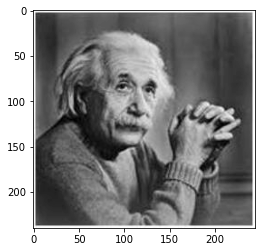

In [2]:
image = io.imread("./images/einstein.jpg", 0)
plt.imshow(image, cmap="gray")
plt.show()

### 2D Convolution

In [3]:
def apply(image, kernel):

    flipped_kernel = np.flip(kernel)

    _, K = flipped_kernel.shape
    N, M = image.shape

    result = np.zeros((N, M), dtype=np.int32)
    center = K // 2
    for i in range(N):
        for j in range(M):
            for k in range(K):
                for l in range(K):
                    ni = k - center
                    nj = l - center
                    if i + ni >= 0 and i + ni < N and j + nj >= 0 and j + nj < M:
                        result[i][j] += np.floor(
                            image[i + ni][j + nj] * flipped_kernel[k][l]
                        )
    return result

### Mean Filter (Blurring)

In [4]:
blur_kernel = np.array(
    [[1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9]],
    dtype=np.float32,
)
blur_output = apply(image, blur_kernel)

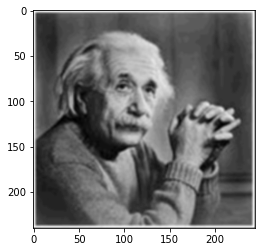

In [5]:
plt.imshow(blur_output, cmap="gray")
plt.show()

### Weighted Average Filter (Blurring)

In [6]:
weighted_average_kernel = np.array(
    [[1 / 16, 2 / 16, 1 / 16], [2 / 16, 4 / 16, 2 / 16], [1 / 16, 2 / 16, 1 / 16]],
    dtype=np.float32,
)
weighted_average_output = apply(image, weighted_average_kernel)

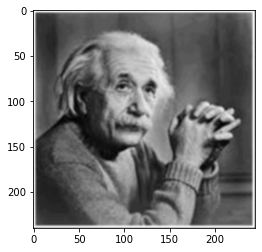

In [7]:
plt.imshow(weighted_average_output, cmap="gray")
plt.show()

### Prewitt Kernel (Edge Detection)

In [8]:
prewitt_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
prewitt_output = apply(image, prewitt_kernel)

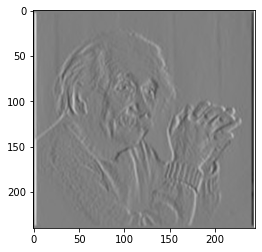

In [9]:
plt.imshow(prewitt_output, cmap="gray")
plt.show()

In [10]:
prewitt_vertical_kernel = np.array(
    [[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32
)
prewitt_vertical_output = apply(image, prewitt_vertical_kernel)

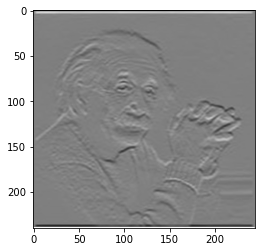

In [11]:
plt.imshow(prewitt_vertical_output, cmap="gray")
plt.show()

### Negative Laplacian Operator (Second Derivative Filter and detects Inward Edges)

In [12]:
laplacian_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32)
laplacian_output = apply(image, laplacian_kernel)

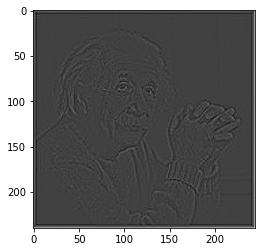

In [13]:
plt.imshow(laplacian_output, cmap="gray")
plt.show()

# Histogram

In [14]:
def hist_eq(img):
    assert (
        img.dtype != np.float16 and img.dtype != np.float32 and img.dtype != np.float64
    )
    flatten_image = img.flatten()
    total = len(flatten_image)
    mini = np.abs(flatten_image.min())
    flatten_image += mini
    freq = np.zeros(flatten_image.max() + 1, dtype=np.int32)
    for i in flatten_image:
        freq[i] += 1
    cdf = np.zeros(flatten_image.max() + 1, dtype=np.float32)
    for i in range(flatten_image.max() + 1):
        if i > 0:
            cdf[i] = cdf[i - 1]
        cdf[i] += freq[i]
    cdf /= total
    histogram_equalized_image = np.zeros(img.shape, dtype=np.int32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            histogram_equalized_image[i][j] = np.floor(cdf[img[i][j]] * 255)
    return histogram_equalized_image

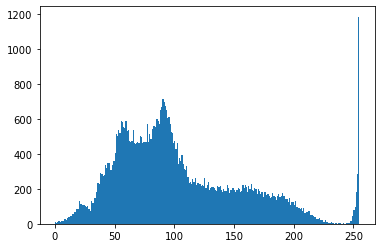

In [15]:
plt.hist(image.flatten(), bins=255)
plt.show()

### Histogram Equalized Image

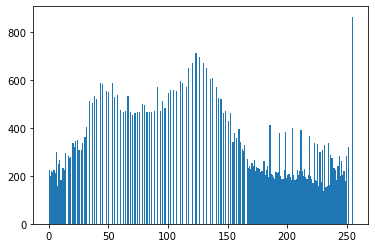

In [16]:
histogram_equalized_image = hist_eq(image)
plt.hist(histogram_equalized_image.flatten(), bins=255)
plt.show()

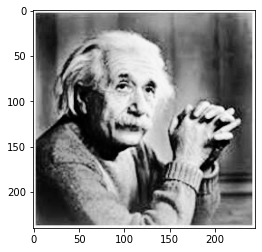

In [17]:
plt.imshow(histogram_equalized_image, cmap="gray")
plt.show()

# Image Enhancements
1. Linear
1. Logarithmic
1. Power Law

In [18]:
def negative_transform(img):
    new_img = img.max() - img
    return new_img

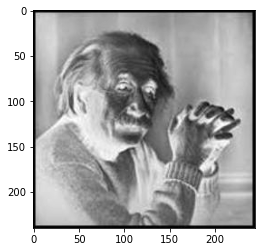

In [19]:
plt.imshow(negative_transform(image), "gray")
plt.show()

In [20]:
def log_transform(img, c):
    new_img = np.array(img, copy=True, dtype=np.int32)
    new_img = c * np.log(new_img + 1)
    return new_img

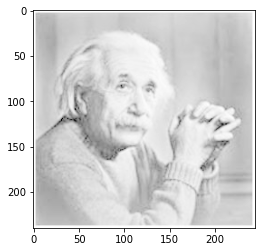

In [21]:
plt.imshow(log_transform(image, 5), "gray")
plt.show()

In [22]:
def power_transform(img, c, gamma):
    new_img = np.array(img, copy=True, dtype=np.int64)
    new_img = c * np.power(new_img, gamma)
    return new_img

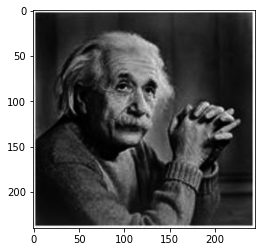

In [23]:
plt.imshow(power_transform(image, 1, 1.8), "gray")
plt.show()

# Interpolation

* Fill in the missing values while zooming in the image or if values were already missing
* It uses the already present data in it's neighbors to reconstruct the missing values

### 1. Nearest Neighbor Interpolation
* Simple but output has reactangular curves rather than smooth curves

In [24]:
def zoom_image_nearest_neighbor(img, times):
    N = img.shape[0]
    M = img.shape[1]
    new_img = np.zeros((N * times, M * times), dtype=np.int32)
    for i in range(N):
        for j in range(M):
            new_img[i * times][j * times] = img[i][j]

    for i in range(N * times):
        for j in range(M * times):
            if i % times == 0 and j % times == 0:
                continue
            li = (i // times) * times
            lj = (j // times) * times
            ri = li + times
            rj = lj + times
            mini = li
            minj = lj
            if ri < N * times and ri - i < i - li:
                mini = ri
            if rj < M * times and rj - j < j - lj:
                minj = rj
            new_img[i][j] = new_img[mini][minj]
    return hist_eq(new_img)

In [25]:
Image.fromarray(zoom_image_nearest_neighbor(image, 10)).show()

### 2. Bilinear Interpolation
* Weighted average of four neighbours
* High time complexity but smoother curves

In [26]:
def zoom_image_bilinear(img, times):
    N = img.shape[0]
    M = img.shape[1]
    new_img = np.zeros((N * times, M * times), dtype=np.int32)
    for i in range(N):
        for j in range(M):
            new_img[i * times][j * times] = img[i][j]

    for i in range(N * times):
        for j in range(M * times):
            if i % times == 0 and j % times == 0:
                continue
            li = (i // times) * times
            lj = (j // times) * times
            ri = li + times
            rj = lj + times
            pixel = (i - li) * (j - lj) * new_img[li][lj]
            if ri < N * times:
                pixel += (ri - i) * (j - lj) * new_img[ri][lj]
            if rj < M * times:
                pixel += (i - li) * (rj - j) * new_img[li][rj]
            if ri < N * times and rj < M * times:
                pixel += (ri - i) * (rj - j) * new_img[ri][rj]
            new_img[i][j] = pixel
    return hist_eq(new_img)

In [27]:
Image.fromarray(zoom_image_bilinear(image, 10)).show()

# Downsampling

* Downsampling is useful technique for image compression or zooming out the original image

### 1. Max 2D Conv stride = sz, kernel_size = sz x sz, output_sz = (h/sz x w/sz)

In [19]:
def downsample_max2D(img, sz):
    [N, M] = img.shape
    downsampled_image = np.zeros((N // sz, M // sz))
    for i in range(0, N - sz + 1, sz):
        for j in range(0, M - sz + 1, sz):
            for k in range(sz):
                for l in range(sz):
                    downsampled_image[i // sz][j // sz] = max(
                        downsampled_image[i // sz][j // sz], img[i + k][j + l]
                    )
    return downsampled_image

In [20]:
Image.fromarray(downsample_max2D(image, 4)).show()

### 2. Average 2D Conv, stride = sz, kernel_size = sz x sz, output_sz = (h/sz x w/sz)

In [27]:
def downsample_avg2D(img, sz):
    [N, M] = img.shape
    downsampled_image = np.zeros((N // sz, M // sz))
    for i in range(0, N - sz + 1, sz):
        for j in range(0, M - sz + 1, sz):
            for k in range(sz):
                for l in range(sz):
                    downsampled_image[i // sz][j // sz] += img[i + k][j + l]
            downsampled_image[i // sz][j // sz] /= sz * sz
    return downsampled_image

In [25]:
Image.fromarray(downsample_avg2D(image, 2)).show()